# Neural network for Time-to-event analysis
link: https://towardsdatascience.com/how-to-implement-deep-neural-networks-for-time-to-event-analyses-9aa0aeac4717

In [147]:

import pandas as pd
import numpy as np
import sklearn_pandas
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper
import seaborn as sns

sns.set_style("white")

import torch # For building the networks 
import torchtuples as tt # Some useful functions
from torch import nn
import torch.nn.functional as F

from pycox.datasets import support
from pycox.models import DeepHitSingle
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv
from pycox.preprocessing.feature_transforms import OrderedCategoricalLong
from pycox.models.loss import rank_loss_deephit_single


from sksurv.datasets import load_gbsg2
from sklearn.preprocessing import OrdinalEncoder
from sksurv.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sksurv.datasets import load_breast_cancer
from sksurv.ensemble import ComponentwiseGradientBoostingSurvivalAnalysis
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder

## Preprocessing

- Numeric variables: Standardize
- Binary variables: No preprocessing necessary
- Categorical variables: Create embeddings

In [148]:
X, y = load_gbsg2()

grade_str = X.loc[:, "tgrade"].astype(object).values[:, np.newaxis]
grade_num = OrdinalEncoder(categories=[["I", "II", "III"]]).fit_transform(grade_str)

X_no_grade = X.drop("tgrade", axis=1)
Xt = OneHotEncoder().fit_transform(X_no_grade)
Xt.loc[:, "tgrade"] = grade_num

# Next, the data is split into 75% for training and 25% for testing, so we can determine how well our model generalizes.


random_state = 20

X_train, X_test, y_train, y_test = train_test_split(
    Xt, y, test_size=0.25, random_state=random_state)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=random_state)

In [149]:
df_train = X_train
df_train['time'] = y_train['time']
df_train['cens'] = y_train['cens']

df_test = X_test
df_test['time'] = y_test['time']
df_test['cens'] = y_test['cens']

df_val = X_val
df_val['time'] = y_val['time']
df_val['cens'] = y_val['cens']

X_test_sorted = df_test.sort_values(by=["pnodes", "age"])
df_test_sel = pd.concat((X_test_sorted.head(3), X_test_sorted.tail(3)))
df_test_sel

,age,estrec,horTh=yes,menostat=Post,pnodes,progrec,tsize,tgrade,time,cens
119,33.0,0.0,0.0,0.0,1.0,26.0,35.0,2.0,1164.0,True
574,34.0,37.0,0.0,0.0,1.0,0.0,40.0,2.0,1108.0,True
421,36.0,14.0,0.0,0.0,1.0,76.0,36.0,1.0,545.0,True
24,65.0,64.0,0.0,1.0,26.0,2.0,70.0,2.0,379.0,True
8,80.0,59.0,0.0,1.0,30.0,0.0,39.0,1.0,471.0,True
226,72.0,1091.0,1.0,1.0,36.0,2.0,34.0,2.0,515.0,True


In [150]:
df_test_sel

,age,estrec,horTh=yes,menostat=Post,pnodes,progrec,tsize,tgrade,time,cens
119,33.0,0.0,0.0,0.0,1.0,26.0,35.0,2.0,1164.0,True
574,34.0,37.0,0.0,0.0,1.0,0.0,40.0,2.0,1108.0,True
421,36.0,14.0,0.0,0.0,1.0,76.0,36.0,1.0,545.0,True
24,65.0,64.0,0.0,1.0,26.0,2.0,70.0,2.0,379.0,True
8,80.0,59.0,0.0,1.0,30.0,0.0,39.0,1.0,471.0,True
226,72.0,1091.0,1.0,1.0,36.0,2.0,34.0,2.0,515.0,True


__Process X's__

In [151]:
cols_std = ['age', 'estrec', 'pnodes', 'progrec', 'tsize'] # numeric variables
cols_bin = ['horTh=yes','menostat=Post'] # binary variables
cols_cat = ['tgrade'] # categorical variables

standardize = [([col], StandardScaler()) for col in cols_std]
leave = [(col, None) for col in cols_bin]
categorical = [(col, OrderedCategoricalLong()) for col in cols_cat]

x_mapper_float = DataFrameMapper(standardize + leave)
x_mapper_long = DataFrameMapper(categorical)  # we need a separate mapper to convert data to 'int64'

x_fit_transform = lambda df: tt.tuplefy(np.asarray(x_mapper_float.fit_transform(df), dtype = np.float32), x_mapper_long.fit_transform(df))
x_transform = lambda df: tt.tuplefy(np.asarray(x_mapper_float.transform(df), dtype = np.float32), x_mapper_long.transform(df))

x_train = x_fit_transform(df_train)
x_val = x_transform(df_val)
x_test = x_transform(df_test)
x_test_sel = x_transform(df_test_sel)

In [152]:
# x_test_sel

In [153]:
x_val = (np.asanyarray(x_val[0], dtype = np.float32),x_val[1])
tt.tuplefy(np.asanyarray(x_val[0], dtype = np.float32),x_val[1])

(array([[-2.26819611e+00, -3.71356964e-01,  2.44711712e-02,
         -2.68246680e-01, -6.03145719e-01,  0.00000000e+00,
          0.00000000e+00],
        [-1.95497680e+00, -4.72701937e-01,  1.53189540e+00,
         -4.55914378e-01, -4.70301837e-01,  0.00000000e+00,
          0.00000000e+00],
        [-2.26819611e+00, -5.48710704e-01,  3.60460353e+00,
         -5.32906294e-01,  1.85446608e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 1.07281005e+00, -8.63242075e-02,  7.78183281e-01,
         -2.10502788e-01, -2.71036029e-01,  0.00000000e+00,
          1.00000000e+00],
        [-3.88880104e-01, -4.66367871e-01, -5.40812910e-01,
          6.12347901e-01,  8.58136952e-01,  1.00000000e+00,
          0.00000000e+00],
        [-7.02099442e-01, -3.90359133e-01,  1.90875137e+00,
         -5.08846283e-01,  2.05373192e+00,  1.00000000e+00,
          0.00000000e+00],
        [ 6.55184329e-01, -3.08016360e-01, -7.29240894e-01,
          3.52500290e-01, -8.68833482e-01,  1.00000000e+00

## DeepHit
DeepHit is a deep learning model adapted to survival (time-to-event) analyses. It can be modified for use investigating single risks or competing risks. Since this is a discrete-time model, the first step in our investigation is to define discrete times to evaluate. We'll create 10 equally spaced (equidistant) discrete time intervals or quantiles using the code below.

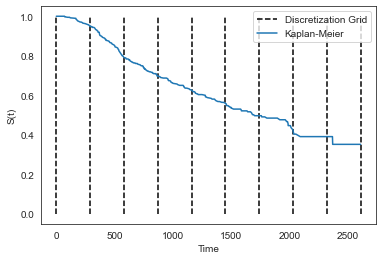

In [154]:
num_durations = 10
scheme = 'equidistant' # or quantiles
labtrans = DeepHitSingle.label_transform(num_durations, scheme)
get_target = lambda df: (df['time'].values, df['cens'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)

# Plotting discrete intervals
from pycox.utils import kaplan_meier
plt.vlines(labtrans.cuts, 0, 1, colors='black', linestyles="--", label='Discretization Grid')
kaplan_meier(*get_target(df_train)).plot(label='Kaplan-Meier')
plt.ylabel('S(t)')
plt.legend()
_ = plt.xlabel('Time')

__Note__


In the event you may be using a different dataset without the need for categorical embeddings, you would require some modifications to your code. First, you would not require the first two lines defining our embeddings. Second, you would need to remove num_embeddings and embeddings_dims from the third block of code. Finally, you would need to substitute VanillaMLP for MixedInputMLP in the third block of code. The MixedInputMLP applies entity embeddings to the categorical variables and concatenates them with our other variables.



Finding the appropriate learning rate is a common problem when training a model. You will often find a wide range in the literature. A very helpful tool available in pycox is the learning rate finder. Although it may not provide the best learning rate, it gives you a good place to start your experimentation. Implementation can be performed using the following code, which gave us a value of 0.04.

In [155]:
num_embeddings = x_train[1].max(0) + 1
embedding_dims = num_embeddings // 2

in_features = x_train[0].shape[1]
out_features = labtrans.out_features
num_nodes = [64, 64]
batch_norm = True
dropout = 0.2

net = tt.practical.MixedInputMLP(in_features, num_embeddings, embedding_dims,
                                 num_nodes, out_features, batch_norm, dropout)
                                 
optimizer = tt.optim.AdamWR(decoupled_weight_decay=0.01, cycle_eta_multiplier=0.8,
                            cycle_multiplier=2)

model = DeepHitSingle(net, optimizer, duration_index=labtrans.cuts)

In [156]:
batch_size = 256
lrfind = model.lr_finder(x_train, y_train, batch_size, tolerance=50)
lrfind.get_best_lr()


0.029150530628251937

In [157]:
model.optimizer.set_lr(0.02)

Now that we have defined all of the model parameters, we fit it using the following code.


In [158]:
epochs = 200
callbacks = [tt.cb.EarlyStoppingCycle()]
verbose = True 

log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val)

0:	[0s / 0s],		train_loss: 0.6989,	val_loss: 0.5324
1:	[0s / 0s],		train_loss: 0.6357,	val_loss: 0.5406
2:	[0s / 0s],		train_loss: 0.5941,	val_loss: 0.5514
3:	[0s / 0s],		train_loss: 0.6593,	val_loss: 0.5400
4:	[0s / 0s],		train_loss: 0.5717,	val_loss: 0.5313
5:	[0s / 0s],		train_loss: 0.4909,	val_loss: 0.5315
6:	[0s / 0s],		train_loss: 0.5086,	val_loss: 0.5340
7:	[0s / 0s],		train_loss: 0.5218,	val_loss: 0.5250
8:	[0s / 0s],		train_loss: 0.4648,	val_loss: 0.5272
9:	[0s / 0s],		train_loss: 0.4716,	val_loss: 0.5309
10:	[0s / 0s],		train_loss: 0.4639,	val_loss: 0.5319
11:	[0s / 0s],		train_loss: 0.4635,	val_loss: 0.5314
12:	[0s / 0s],		train_loss: 0.4680,	val_loss: 0.5293
13:	[0s / 0s],		train_loss: 0.4480,	val_loss: 0.5292
14:	[0s / 0s],		train_loss: 0.4566,	val_loss: 0.5308
15:	[0s / 0s],		train_loss: 0.4512,	val_loss: 0.5205
16:	[0s / 0s],		train_loss: 0.4529,	val_loss: 0.5143
17:	[0s / 0s],		train_loss: 0.4463,	val_loss: 0.5113
18:	[0s / 0s],		train_loss: 0.4638,	val_loss: 0.5090
19:

# Evaluate the model

To evaluate our model, we can begin by looking at some predictions on our test data. The code for this (figure 10) plots the predicted survival for five patients. The interpolate function on the first line creates a linear interpolation to smooth out the steps across time (remember this is a discrete-time model). The plot can be seen directly below the code.



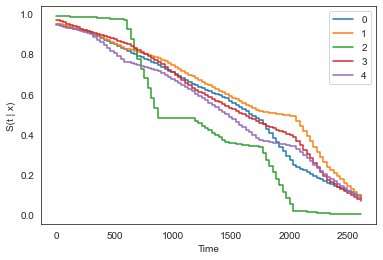

In [159]:
surv = model.interpolate(10).predict_surv_df(x_test)
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

# Brier score
To evaluate how well the model performed on our test set, there are several metrics available. I will present the inverse probability of censoring weighting (IPCW) Brier score. This calculates the mean squared error (MSE) for the predicted outcome with the actual outcome at each discrete time interval we defined. Since the MSE of a correct prediction would be 0, a lower score indicates a better performance.

We can plot the performance over time using the following code. The first block allows us to plot the Brier score across time (figure 13). The integrated score can also be calculated (line 6), which resulted in a value of 0.21 (79% accuracy).

In [160]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
ev.concordance_td('antolini')


0.6726939203354297

0.20018755682507772

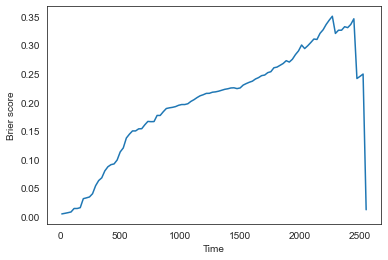

In [161]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

ev.integrated_brier_score(time_grid)

# DeepSurv

DeepSurv is another option for incorporating the potential of deep neural networks in time-to-event analyses. The main difference is that this a continuous-time model, meaning we won’t need to define discrete intervals as we did with DeepHit. Here, we simply transform our labels as seen below.



In [162]:
cols_std = ['age', 'estrec', 'pnodes', 'progrec', 'tsize','tgrade']
cols_ = ['horTh=yes','menostat=Post'] 


standardize = [([col], StandardScaler()) for col in cols_std]
leave = [(col, None) for col in cols_]


x_mapper = DataFrameMapper(standardize + leave)


x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')
x_test_sel = x_mapper.transform(df_test_sel).astype('float32')


get_target = lambda df: (df['time'].values, df['cens'].values)
y_train = get_target(df_train)
y_val = get_target(df_val)
y_test = get_target(df_test)
durations_test, events_test = get_target(df_test)
val = x_val, y_val

The rest is similar to above, where we define our model and fit it to our data. As you can see (figure 15), the main difference is on line 3 where out_features = 1. This, once again, is due to the fact that we are working with a continuous-time model, whereas with DeepHit this was set to the number of discrete intervals that we defined. One thing worth noting is that the learning rate for this model was 0.07 (versus 0.04 for DeepHit) as determined by the learning rate finder.



In [163]:

in_features = x_train.shape[1]
num_nodes = [64, 64]
out_features = 1
batch_norm = True
dropout = 0.2
output_bias = False

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout, output_bias=output_bias)
                              
model = CoxPH(net, optimizer ) 

epochs = 100
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val, val_batch_size=batch_size)

0:	[0s / 0s],		train_loss: 4.7073,	val_loss: 4.4241
1:	[0s / 0s],		train_loss: 4.6305,	val_loss: 4.3893
2:	[0s / 0s],		train_loss: 4.7119,	val_loss: 4.3576
3:	[0s / 0s],		train_loss: 4.5958,	val_loss: 4.3337
4:	[0s / 0s],		train_loss: 4.5390,	val_loss: 4.3168
5:	[0s / 0s],		train_loss: 4.5859,	val_loss: 4.3036
6:	[0s / 0s],		train_loss: 4.5249,	val_loss: 4.2947
7:	[0s / 0s],		train_loss: 4.4703,	val_loss: 4.2874
8:	[0s / 0s],		train_loss: 4.5763,	val_loss: 4.2812
9:	[0s / 0s],		train_loss: 4.5392,	val_loss: 4.2764
10:	[0s / 0s],		train_loss: 4.5027,	val_loss: 4.2727
11:	[0s / 0s],		train_loss: 4.4730,	val_loss: 4.2684
12:	[0s / 0s],		train_loss: 4.5266,	val_loss: 4.2657
13:	[0s / 0s],		train_loss: 4.4553,	val_loss: 4.2637
14:	[0s / 0s],		train_loss: 4.4559,	val_loss: 4.2626
15:	[0s / 0s],		train_loss: 4.4796,	val_loss: 4.2612
16:	[0s / 0s],		train_loss: 4.4477,	val_loss: 4.2606
17:	[0s / 0s],		train_loss: 4.5114,	val_loss: 4.2602
18:	[0s / 0s],		train_loss: 4.5019,	val_loss: 4.2597
19:

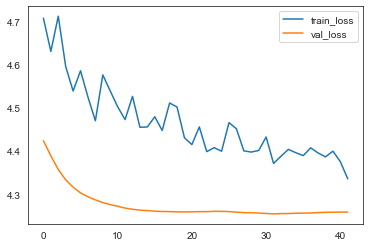

In [164]:
_ = log.plot()


EVALUATING

In [165]:
_ = model.compute_baseline_hazards()


In [166]:
surv = model.predict_surv_df(x_test)


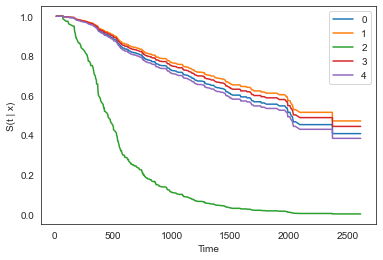

In [167]:
surv.iloc[:, :5].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [168]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
ev.concordance_td()


0.6662303664921466

In [169]:
ev.integrated_brier_score(time_grid)


0.17329082762544695

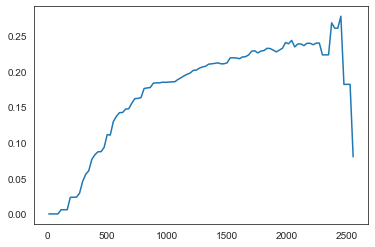

In [170]:

time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
_ = ev.brier_score(time_grid).plot()

In [171]:
model.predict(x_test)

array([[-0.27719945],
       [-0.45428124],
       [ 1.6530709 ],
       [-0.37702245],
       [-0.2117263 ],
       [ 0.32182974],
       [-0.30265203],
       [ 0.11844349],
       [ 0.21973549],
       [-0.27022249],
       [-1.0887077 ],
       [-0.15965408],
       [ 0.23813368],
       [-0.31206188],
       [ 0.4587062 ],
       [-0.32406121],
       [-0.0803835 ],
       [-0.05208518],
       [ 0.68629336],
       [ 0.894503  ],
       [ 0.651998  ],
       [-0.1299572 ],
       [ 0.01666008],
       [ 0.44033033],
       [ 0.10474002],
       [ 0.32989335],
       [-0.25752807],
       [-0.19695717],
       [-0.11629332],
       [-0.22982703],
       [-0.32626712],
       [ 0.6518711 ],
       [ 0.00321528],
       [ 0.62754095],
       [-0.08954425],
       [-0.38737208],
       [ 0.5418844 ],
       [-0.01025466],
       [ 0.31207263],
       [-0.37467894],
       [-0.2454067 ],
       [-0.01333819],
       [-0.07792972],
       [ 0.8457099 ],
       [-0.38657415],
       [ 0

In [178]:
df_test_sel['pred'] = model.predict(x_test_sel)
df_test_sel

,age,estrec,horTh=yes,menostat=Post,pnodes,progrec,tsize,tgrade,time,cens,pred
119,33.0,0.0,0.0,0.0,1.0,26.0,35.0,2.0,1164.0,True,0.151004
574,34.0,37.0,0.0,0.0,1.0,0.0,40.0,2.0,1108.0,True,0.138223
421,36.0,14.0,0.0,0.0,1.0,76.0,36.0,1.0,545.0,True,-0.053808
24,65.0,64.0,0.0,1.0,26.0,2.0,70.0,2.0,379.0,True,1.346173
8,80.0,59.0,0.0,1.0,30.0,0.0,39.0,1.0,471.0,True,1.416199
226,72.0,1091.0,1.0,1.0,36.0,2.0,34.0,2.0,515.0,True,1.653071


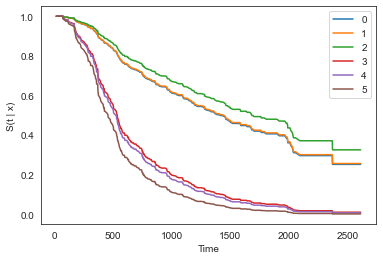

In [179]:
surv = model.predict_surv_df(x_test_sel)
surv.plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')